In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFile
import pandas as pd
import seaborn as sns
import networkx as nx
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from graphutils import GraphUtils
from randomwalkkernel import RandomWalkKernel
from shortestpathkernel import ShortestPathKernel

# 14, 17, 29, 38, 56!!!
dataset_index = 56
img_path = f"../TrainingDataset/TrainingData/Images/{dataset_index}.png"
td_data_path = f"../TrainingDataset/TrainingData/TD/TD_scanpath_{dataset_index}.txt"
asd_data_path = f"../TrainingDataset/TrainingData/ASD/ASD_scanpath_{dataset_index}.txt"
td_data = pd.read_csv(td_data_path, usecols=[0, 1, 2, 3])
asd_data = pd.read_csv(asd_data_path, usecols=[0, 1, 2, 3])
td_data.columns = ["idx", "x", "y", "t"]
asd_data.columns = ["idx", "x", "y", "t"]
image = Image.open(img_path)


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: '../TrainingDataset/TrainingData/TD/TD_scanpath_56.txt'

[Text(0.5, 1.0, 'ASD')]

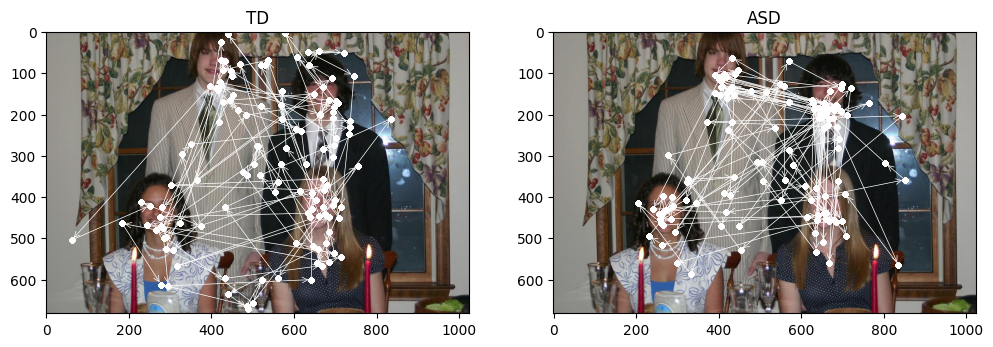

In [216]:
def trace_plot(ax, df: pd.DataFrame):
    for i in range(len(df.index) - 1):
        ax.annotate(
            "",
            xy=(df["x"][i + 1], df["y"][i + 1]),
            xytext=(df["x"][i], df["y"][i]),
            arrowprops=dict(arrowstyle="->", color="white", lw=0.5),
        )
        ax.scatter(df["x"], df["y"], color="white", marker=".")

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
trace_plot(ax[0], asd_data),
ax[0].imshow(image)
ax[0].set(title="TD")

trace_plot(ax[1], td_data),
ax[1].imshow(image)
ax[1].set(title="ASD")

In [ ]:
def cluster(k_clusters: int, df: pd.DataFrame) -> tuple[pd.DataFrame, float]:

    X = df[["x", "y"]]
    kmeans = KMeans(n_clusters=k_clusters, random_state=0)
    kmeans.fit(X)
    df_copy = df.copy()
    df_copy["AOI"] = kmeans.labels_

    return df_copy, kmeans.inertia_


def clustering(min_clusters: int, max_clusters: int, df: pd.DataFrame) -> tuple[dict[int, pd.DataFrame], dict[int, float]]:
    """Input:
    - min_clusters: inclusive
    - max_clusters: inclusive
    - data: has x,y columns, temporal order

    Return:
    - dict of k - fitted df, and dict of k - inertias
    """
    dfs:  dict[int, pd.DataFrame] = {}
    inertias: dict[int, float] = {}

    cluster_numbers = range(min_clusters, max_clusters+1)
    for k in cluster_numbers:
        df_copy, inertia = cluster(k, df)
        dfs[k] = df_copy
        inertias[k] = inertia

    return dfs, inertias


def transition_matrix(df: pd.DataFrame, normalize: bool=False) -> np.ndarray:
    """
    Inputs:
    - aoi: df with needed columns x, y
    - data: df wiht needed columns AOI
    
    Returns
    - n x n transition matrix, where n is the number of AOIs
    """

    # from \ to -> row \ col
    AOIS = len(df["AOI"].unique())
    transition_matrix = np.zeros(shape=(AOIS, AOIS), dtype=int)
    for i in range(len(df.index)-1):
        from_aoi = df.loc[i, "AOI"]
        to_aoi = df.loc[i+1, "AOI"]
        transition_matrix[from_aoi][to_aoi] += 1
    #rows_sum = np.sum(transition_matrix, axis=1)
    return transition_matrix #/ rows_sum


def elbow_plot(inertias: dict[int, float]) -> None:
    k_values, inertia_values = zip(*inertias.items())
    knee_locator = KneeLocator(k_values, inertia_values, curve='convex', direction='decreasing')
    k = knee_locator.knee
    _, ax = plt.subplots(1, 1, figsize=(6.5, 4))
    ax.plot(k_values, inertia_values, marker='o')
    ax.axvline(x=k, color="red")
    ax.set(xlabel='Number of clusters [-]', ylabel='Inertia [-]', title=f'Elbow method for optimal k')
    ax.set_xticks(k_values)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))


def cluster_plot(df: pd.DataFrame, image: ImageFile, ax):
    sns.scatterplot(data=df, x='x', y='y', hue='AOI', palette='deep', s=80, ax=ax)
    ax.imshow(image)

def cluster_plots(dfs: dict[int, pd.DataFrame], image: ImageFile, title: str=""):
    fig, axs = plt.subplots(nrows=1, ncols=len(dfs), figsize=(30, 4))
    fig.suptitle(title)
    for i, kv in enumerate(dfs.items()):
        k, df = kv
        cluster_plot(df, image, axs[i])


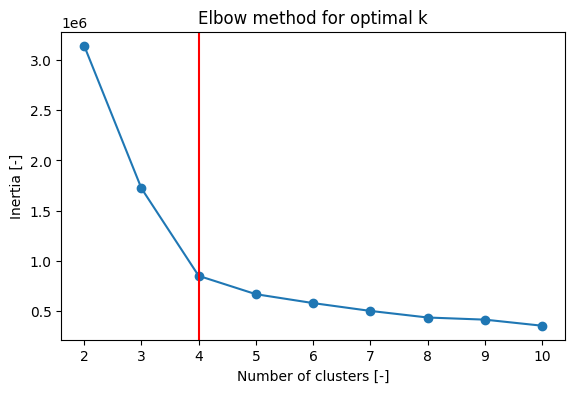

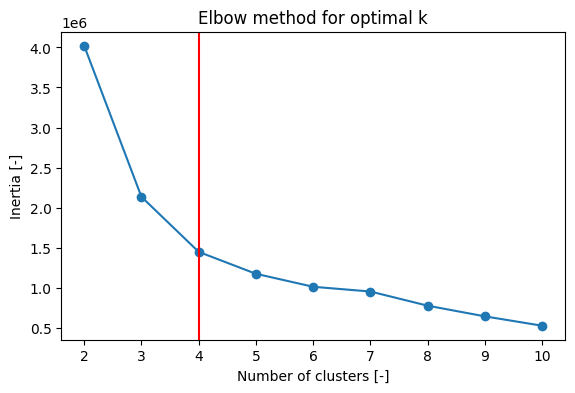

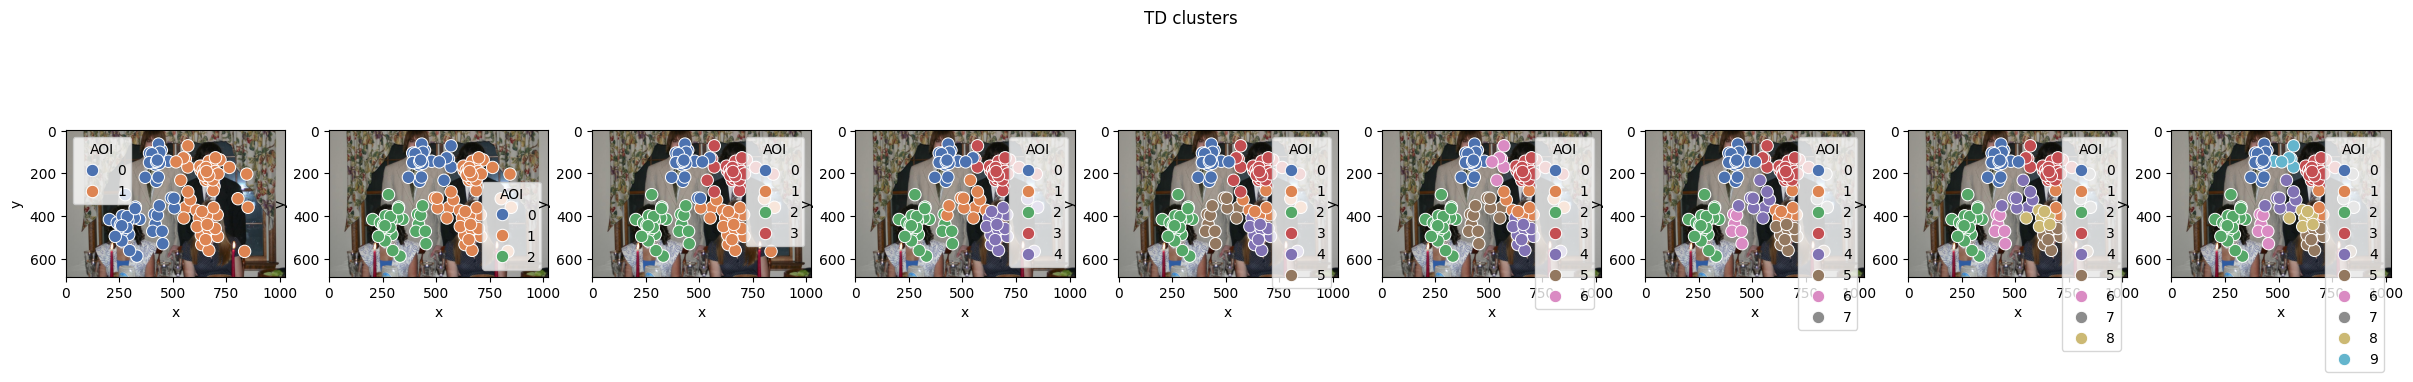

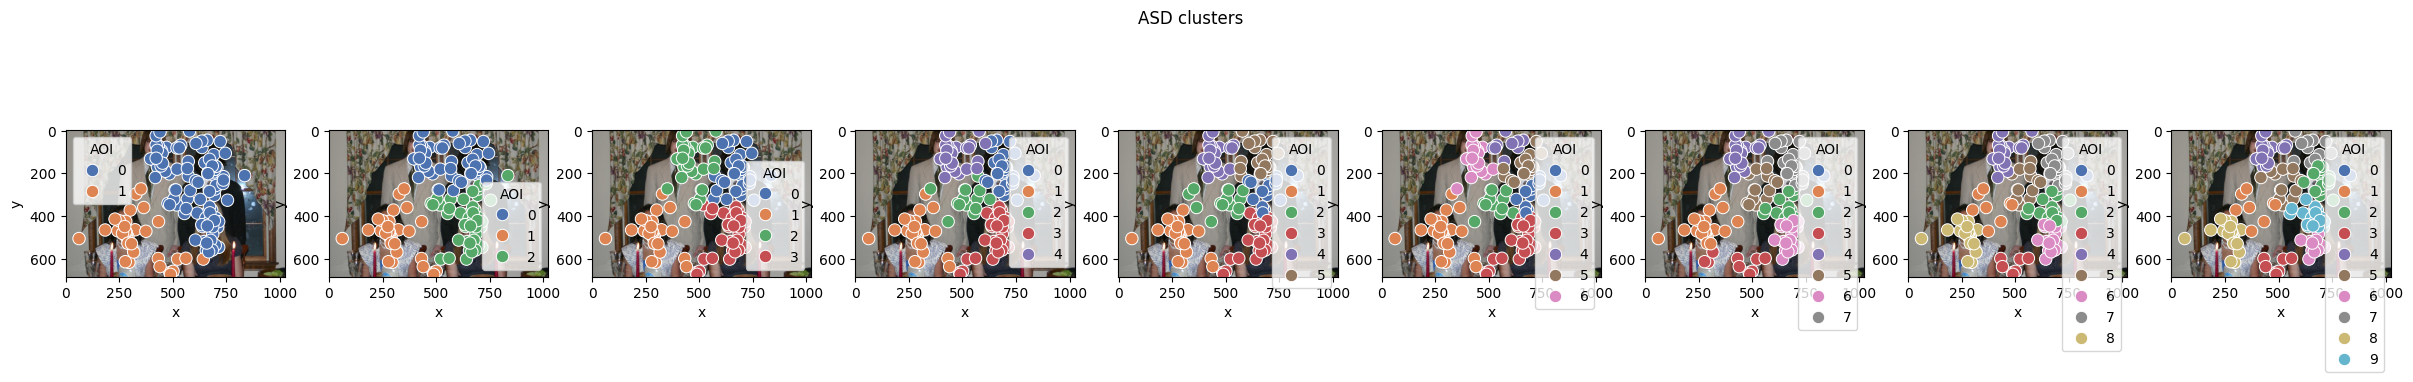

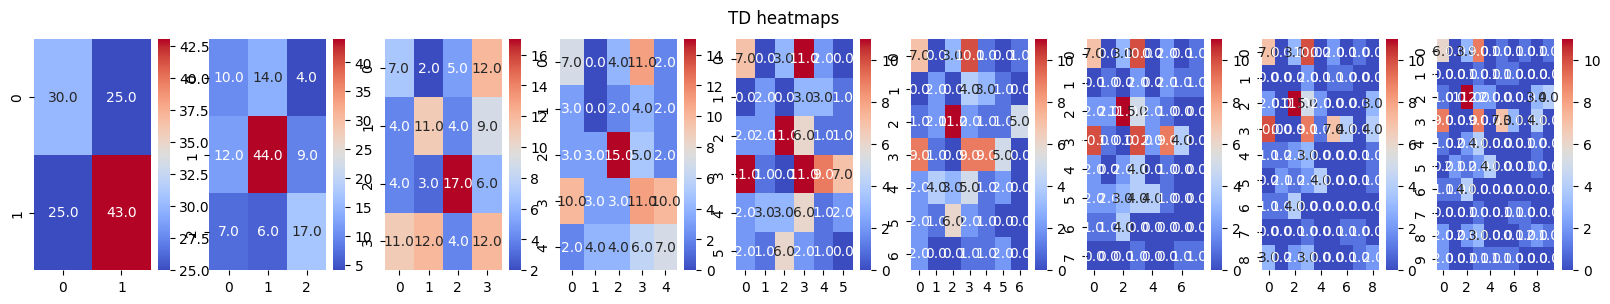

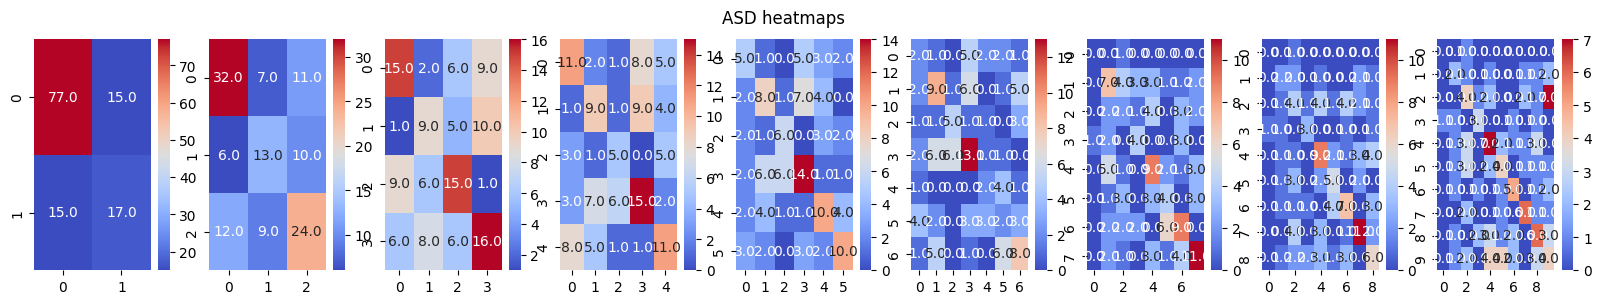

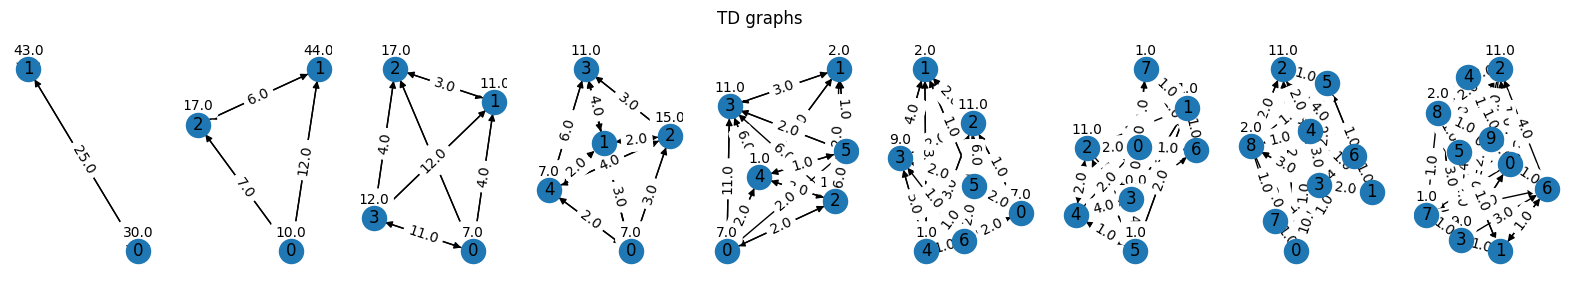

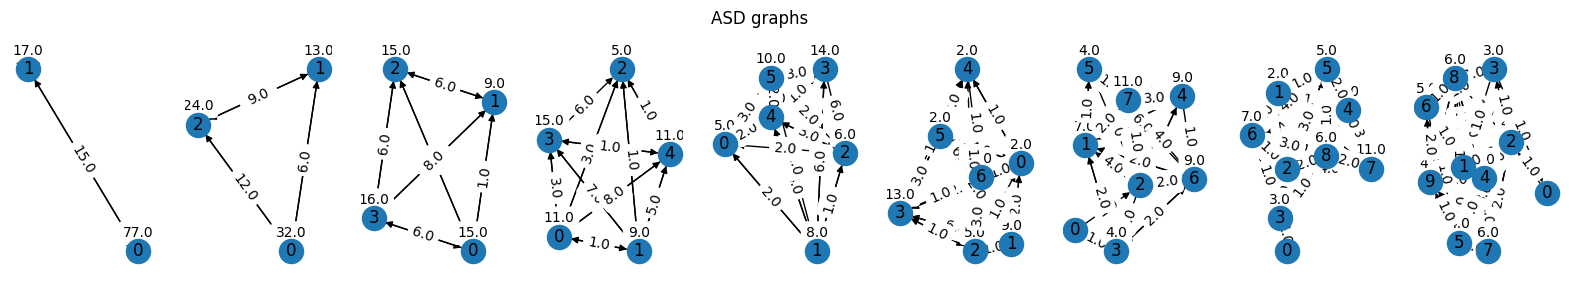

In [305]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10
td_dfs, td_inertias = clustering(MIN_CLUSTERS, MAX_CLUSTERS, td_data)
asd_dfs, asd_inertias = clustering(MIN_CLUSTERS, MAX_CLUSTERS, asd_data)

elbow_plot(td_inertias)
elbow_plot(asd_inertias)

cluster_plots(td_dfs, image, "TD clusters")
cluster_plots(asd_dfs, image, "ASD clusters")

td_matrices = []
td_matrices_norm = []
td_graphs = []
asd_matrices = []
asd_matrices_norm = []
asd_graphs = []

td_fig_maps, td_axs_maps = plt.subplots(nrows=1, ncols=len(td_dfs), figsize=(20, 3))
td_fig_maps.suptitle("TD heatmaps")
for i, df in enumerate(td_dfs.values()):
    m = GraphUtils.transition_matrix(df)
    m_norm = GraphUtils.transition_matrix(df, normalize=True)
    td_matrices.append(m)
    td_matrices_norm.append(m_norm)
    GraphUtils.heatmap(m, td_axs_maps[i])

asd_fig_maps, asd_axs_maps = plt.subplots(nrows=1, ncols=len(asd_dfs), figsize=(20, 3))
asd_fig_maps.suptitle("ASD heatmaps")
for i, df in enumerate(asd_dfs.values()):
    m = GraphUtils.transition_matrix(df)
    m_norm = GraphUtils.transition_matrix(df, normalize=True)
    asd_matrices.append(m)
    asd_matrices_norm.append(m_norm)
    GraphUtils.heatmap(m, asd_axs_maps[i])

td_fig_graphs, td_axs_graphs = plt.subplots(nrows=1, ncols=len(td_dfs), figsize=(20, 3))
td_fig_graphs.suptitle("TD graphs")
for i, df in enumerate(td_dfs.values()):
    m = GraphUtils.transition_matrix(df)
    g = GraphUtils.transition_matrix_to_graph(m)
    td_graphs.append(g)
    GraphUtils.draw(G=g, weights=True, ax=td_axs_graphs[i])


asd_fig_graphs, asd_axs_graphs = plt.subplots(nrows=1, ncols=len(asd_dfs), figsize=(20, 3))
asd_fig_graphs.suptitle("ASD graphs")
for i, df in enumerate(asd_dfs.values()):
    m = GraphUtils.transition_matrix(df)
    g = GraphUtils.transition_matrix_to_graph(m)
    asd_graphs.append(g)
    GraphUtils.draw(G=g, weights=True, ax=asd_axs_graphs[i])

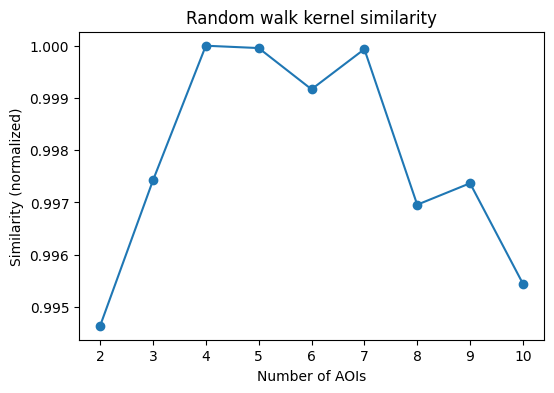

In [306]:
joint_data = list(zip(td_matrices, asd_matrices))
x = [x_ + MIN_CLUSTERS for x_ in range(len(list(joint_data)))]
similarities = []

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set(
    title="Random walk kernel similarity", 
    xlabel="Number of AOIs",
    ylabel="Similarity (normalized)"
)

for (td_m, asd_m) in joint_data:
    similarity = RandomWalkKernel.weighted_random_walk_kernel(td_m, asd_m, normalize=True)
    similarities.append(similarity)

ax.plot(x, similarities, marker="o")

/home/simontitk/projects/python/thesis/src/shortestpathkernel.py:8: RuntimeWarning: divide by zero encountered in log
  G_cost = np.where(G_transition > 0, -np.log(G_transition), np.inf)


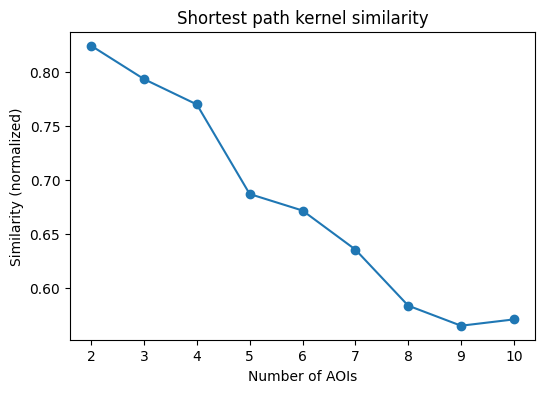

In [307]:
joint_data = list(zip(td_matrices_norm, asd_matrices_norm))
x = [x_ + MIN_CLUSTERS for x_ in range(len(list(joint_data)))]
similarities = []

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set(
    title="Shortest path kernel similarity", 
    xlabel="Number of AOIs",
    ylabel="Similarity (normalized)"
)

for (td_m, asd_m) in joint_data:
    similarity = ShortestPathKernel.get_kernel_value(td_m, asd_m, normalize=True, kernel=ShortestPathKernel.inverse_abs_diff_kernel)
    similarities.append(similarity)

ax.plot(x, similarities, marker="o")

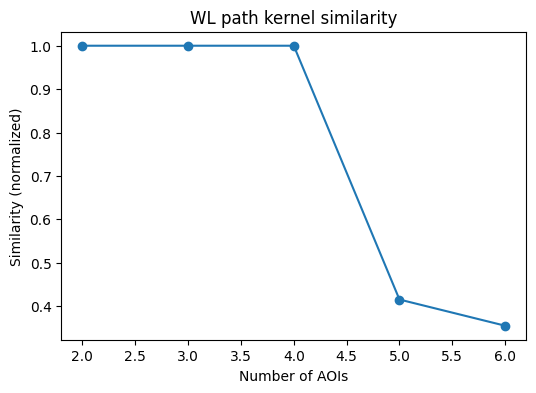

In [ ]:
from wl import WL
from labelhasher import LabelHasher

joint_data = list(zip(td_graphs, asd_graphs))
x = [x_ + MIN_CLUSTERS for x_ in range(len(list(joint_data)))]
similarities = []

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set(
    title="WL path kernel similarity", 
    xlabel="Number of AOIs",
    ylabel="Similarity (normalized)"
)   

for (td_m, asd_m) in joint_data:
    wl = WL(LabelHasher())
    v = wl.get_feature_vectors(td_m, asd_m, n=4)
    similarity = wl.get_kernel_value(v, True)
    similarities.append(similarity)

ax.plot(x, similarities, marker="o")